# Introducing: HistFrames
HistFrames are similar to data frames, but each row corresponds to a bin, like in a histogram. They do not aim to be fully featured histogram objects like you might find in other library, however. Jack of all trades; master of... also all trades.

Firstly, we need to define a binning

In [1]:
import pyNUISANCE as pn

binning = pn.binning.lin_space(50,0,50)

Then we can instantiate an empty HistFrame with this binning

In [2]:
hf = pn.HistFrame(binning, "MCPrediction")
print(hf) #the printer only prints the first 20 rows by default

 ----------------------
 | MCPrediction | err |
 ----------------------
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |          ... | ... |
 ----------------------


We can then add an entry to a bin

In [3]:
evs = pn.EventSource("dune_argon_sf_10mega.nuwro.pb.gz")
if not evs:
    print("Error: failed to open input file")

# just get the first event so that we can check the units
ev,_ = evs.first()
ToGeV = 1 if (ev.momentum_unit() == pn.hm.HepMC3.Units.GEV) else 1E-3

def enu_GeV(ev):
    bpart = pn.pps.sel.Beam(ev,14)
    if bpart:
        return bpart.momentum().e()*ToGeV
    return -0

hf.reset() # reset it so that repeated running of this cell doesn't keep filling the histo
ev, cvw = evs.first()
enu = enu_GeV(ev)
hf.fill(enu, cvw) # for correctly normalizable distributions that work for different generators 
                  # we *always* need to keep track of the weights, even if they're all '1' for 
                  # our testing generator
print(hf)

[2024-02-29 17:13:45.565] [info] Found eventinput plugin: /root/software/NUISANCEMC/eventinput/build/Linux/lib/plugins/nuisplugin-eventinput-GHEP3.so
[2024-02-29 17:13:45.595] [info] Found eventinput plugin: /root/software/NUISANCEMC/eventinput/build/Linux/lib/plugins/nuisplugin-eventinput-NuWroevent1.so
[2024-02-29 17:13:45.599] [info] Found eventinput plugin: /root/software/NUISANCEMC/eventinput/build/Linux/lib/plugins/nuisplugin-eventinput-neutvect.so
[2024-02-29 17:13:45.600] [info] EventSourceFactory: PathResolver::resolve filepath: dune_argon_sf_10mega.nuwro.pb.gz, exists: true
[2024-02-29 17:13:45.750] [info] Reading file dune_argon_sf_10mega.nuwro.pb.gz with native HepMC3EventSource
 ----------------------
 | MCPrediction | err |
 ----------------------
 |            0 |   0 |
 |            0 |   0 |
 |            1 |   1 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |            0 |   0 |
 |          

Lets make a more sensibly binned histogram and fill it with a few events

In [7]:
from math import log
binning = pn.binning.log10_space(50,log(0.1)/log(10),log(8)/log(10), "E_nu [GeV]")
hf = pn.HistFrame(binning) #the default first column name is "mc"
for i, (ev, cvw) in enumerate(evs):
    hf.fill(enu_GeV(ev),cvw)
    if i >= 1E5:
        break

print(hf)

 ---------------
 |  mc |   err |
 ---------------
 |   0 |     0 |
 |   0 |     0 |
 |   0 |     0 |
 |   0 |     0 |
 |   0 |     0 |
 |   1 |     1 |
 |   0 |     0 |
 |   1 |     1 |
 |   0 |     0 |
 |   1 |     1 |
 |  12 | 3.464 |
 |   5 | 2.236 |
 |  12 | 3.464 |
 |  21 | 4.583 |
 |  28 | 5.292 |
 |  28 | 5.292 |
 |  42 | 6.481 |
 |  69 | 8.307 |
 |  94 | 9.695 |
 | 149 | 12.21 |
 | 185 |  13.6 |
 | ... |   ... |
 ---------------


We can interrogate some of the binning metadata like below. The binning information is stored by bin index, this enables fully generic ndimensional binnings to be defined but can make them confusing to work with if you're use to information being stored by axis.

In [8]:
print("Bin extents: %s" % hf.binning.bin_info)

Bin extents: Axis lables: ["E_nu [GeV]"]
Bins: [
  0: [(0.10 - 0.11)]
  1: [(0.11 - 0.12)]
  2: [(0.12 - 0.13)]
  3: [(0.13 - 0.14)]
  4: [(0.14 - 0.15)]
  5: [(0.15 - 0.17)]
  6: [(0.17 - 0.18)]
  7: [(0.18 - 0.20)]
  8: [(0.20 - 0.22)]
  9: [(0.22 - 0.24)]
  10: [(0.24 - 0.26)]
  11: [(0.26 - 0.29)]
  12: [(0.29 - 0.31)]
  13: [(0.31 - 0.34)]
  14: [(0.34 - 0.37)]
  15: [(0.37 - 0.41)]
  16: [(0.41 - 0.44)]
  17: [(0.44 - 0.48)]
  18: [(0.48 - 0.53)]
  19: [(0.53 - 0.58)]
  20: [(0.58 - 0.63)]
  21: [(0.63 - 0.69)]
  22: [(0.69 - 0.75)]
  23: [(0.75 - 0.82)]
  24: [(0.82 - 0.89)]
  25: [(0.89 - 0.98)]
  26: [(0.98 - 1.07)]
  27: [(1.07 - 1.16)]
  28: [(1.16 - 1.27)]
  29: [(1.27 - 1.39)]
  30: [(1.39 - 1.51)]
  31: [(1.51 - 1.65)]
  32: [(1.65 - 1.80)]
  33: [(1.80 - 1.97)]
  34: [(1.97 - 2.15)]
  35: [(2.15 - 2.35)]
  36: [(2.35 - 2.56)]
  37: [(2.56 - 2.79)]
  38: [(2.79 - 3.05)]
  39: [(3.05 - 3.33)]
  40: [(3.33 - 3.64)]
  41: [(3.64 - 3.97)]
  42: [(3.97 - 4.33)]
  43: [(4.33 - 

We can use a simple list comprehension to get the binning along one axis.

In [9]:
bin_centers = [ ((x[0].min + x[0].max) / 2.0) for x in hf.binning.bin_info.extents ]
print("Bin centers: %s" % bin_centers)

Bin centers: [0.104579782927117, 0.11415883701454124, 0.12461529086931576, 0.13602951050093595, 0.14848922309646131, 0.16209019127242208, 0.17693694908527335, 0.19314360545721143, 0.21083472119230656, 0.23014626632350643, 0.2512266651484687, 0.2742379369861385, 0.2993569414216766, 0.3267767376104157, 0.356708068088159, 0.38938097849205977, 0.4250465856409006, 0.46397900756385185, 0.506477470311484, 0.5528686077415228, 0.603508971954994, 0.6587877736774221, 0.7191298736470475, 0.7849990480012183, 0.8569015527579997, 0.9353900147888221, 1.021067679187333, 1.1145930456787954, 1.2166849297044569, 1.3281279870792768, 1.4497787446843153, 1.5825721835443618, 1.727528924886896, 1.8857630744128513, 2.058490785068524, 2.247039604130213, 2.452858676441238, 2.6775298822211653, 2.922779995050006, 3.190493953470988, 3.482729348214516, 3.8017322363889576, 4.149954404182646, 4.5300722107544384, 4.945007158142845, 5.397948345289523, 5.892376978753848, 6.43209312850253, 7.021244934413378, 7.664360487968

Lets make a plot

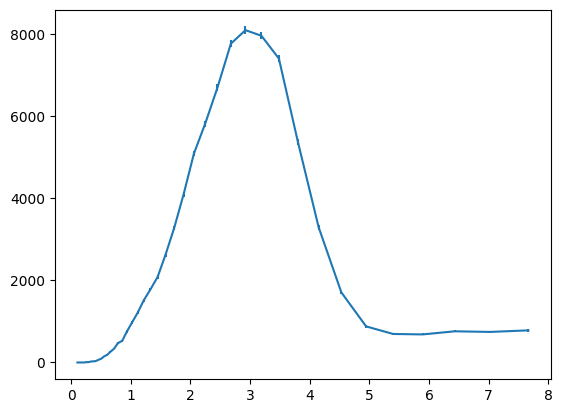

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.errorbar(bin_centers,hf.contents[:,0],yerr=np.sqrt(hf.variance[:,0]))
plt.show()